In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import SpatialGlue
from SpatialGlue.preprocess import fix_seed
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
random_seed = 2022
fix_seed(random_seed)
from SpatialGlue.preprocess import clr_normalize_each_cell, pca, lsi
import time
from memory_profiler import memory_usage
import torch

In [2]:
device_idx = 0

def measure_resources(func):
    def wrapper(*args, **kwargs):
        result = None
        
        start_time = time.time()
        mem, result = memory_usage(
            (func, args, kwargs), 
            max_usage=True, 
            retval=True
        )
        
        mem_usage_gb = mem / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        
        if torch.cuda.is_available():
            try:
                device = torch.device(f"cuda:{device_idx}")
                allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
                cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
            except:
                allocated = cached = 0
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage_gb:.2f} GB")
        print(f"GPU memory allocated: {allocated:.4f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")
        
        return result

    return wrapper

In [3]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset17_Simulation5/' #please replace 'file_fold' with the download path
import numpy as np
adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']
n_protein = adata_omics2.n_vars
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=n_protein)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=n_protein)

In [4]:
@measure_resources
def run_pipeline(adata1, adata2, device):
    data_type = 'SPOTS'
    from SpatialGlue.preprocess import construct_neighbor_graph
    
    data = construct_neighbor_graph(adata1, adata2, datatype=data_type)
    
    from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
    model = Train_SpatialGlue(data, datatype=data_type, device=device)
    
    output = model.train()
    return output
output = run_pipeline(adata_omics1, adata_omics2, device)

/home/dbj/anaconda3/envs/SpatialGlue/lib/python3.8/site-packages/SpatialGlue/preprocess.py:132: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(indices, values, shape)
  0%|                                                                                                                                                                                         | 0/600 [00:00<?, ?it/s]/home/dbj/anaconda3/envs/SpatialGlue/lib/python3.8/site-packages/SpatialGlue/model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Model training finished!

Function 'run_pipeline' executed in 0.0 minutes and 10.6271 seconds.
Memory usage: 1.14 GB
GPU memory allocated: 0.0625 GB
GPU memory cached: 0.08 GB


In [5]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['SpatialGlue'] = output['SpatialGlue'].copy()
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

In [6]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=5, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpatialGlue'])
adata.obs['SpatialGlue']=labels.astype(str)

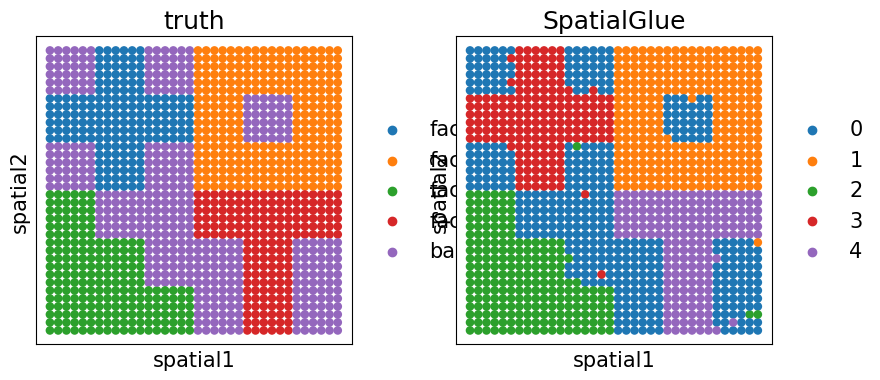

In [7]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,basis='spatial',color=['truth','SpatialGlue'],size=155)

In [8]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata.obs['truth'])
cluster_labels = np.array(adata.obs['SpatialGlue'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.9590691785410762
NMI: 0.9521972409135323
AMI: 0.9520053104838205
FMI: 0.9682863030540555
V-Measure: 0.9521972409135323
Homogeneity: 0.9553899227395136


In [9]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/SpatialGlue/SpatialGlue_sim_5.h5ad',compression='gzip')

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import SpatialGlue
from SpatialGlue.preprocess import fix_seed
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
random_seed = 2024
fix_seed(random_seed)
from SpatialGlue.preprocess import clr_normalize_each_cell, pca, lsi
import time
from memory_profiler import memory_usage
import torch

In [2]:
device_idx = 0

def measure_resources(func):
    def wrapper(*args, **kwargs):
        result = None
        
        start_time = time.time()
        mem, result = memory_usage(
            (func, args, kwargs), 
            max_usage=True, 
            retval=True
        )
        
        mem_usage_gb = mem / 1024
        end_time = time.time()
        execution_time = end_time - start_time
        minutes = execution_time // 60
        seconds = execution_time % 60
        
        if torch.cuda.is_available():
            try:
                device = torch.device(f"cuda:{device_idx}")
                allocated = torch.cuda.memory_allocated(device) / (1024 ** 3) 
                cached = torch.cuda.memory_reserved(device) / (1024 ** 3)
            except:
                allocated = cached = 0
        else:
            allocated = cached = 0

        print(f"Function '{func.__name__}' executed in {minutes} minutes and {seconds:.4f} seconds.")
        print(f"Memory usage: {mem_usage_gb:.2f} GB")
        print(f"GPU memory allocated: {allocated:.4f} GB")
        print(f"GPU memory cached: {cached:.2f} GB")
        
        return result

    return wrapper

In [3]:
data_type = 'Spatial-epigenome-transcriptome'
file_fold = '/home/dbj/mouse/SpatialGlue/Mouse_Brain/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_peaks_normalized.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

In [4]:
data_type = 'Spatial-epigenome-transcriptome'

# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 2024
fix_seed(random_seed)

In [5]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca, lsi

# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.filter_cells(adata_omics1, min_genes=200)

sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=50)

# ATAC
adata_omics2 = adata_omics2[adata_omics1.obs_names].copy() # .obsm['X_lsi'] represents the dimension reduced feature
if 'X_lsi' not in adata_omics2.obsm.keys():
    sc.pp.highly_variable_genes(adata_omics2, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata_omics2, use_highly_variable=False, n_components=51)

adata_omics2.obsm['feat'] = adata_omics2.obsm['X_lsi'].copy()

In [6]:
@measure_resources
def run_pipeline(adata1, adata2, device):
    data_type = 'Spatial-epigenome-transcriptome'
    from SpatialGlue.preprocess import construct_neighbor_graph
    
    data = construct_neighbor_graph(adata1, adata2, datatype=data_type)
    
    from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
    model = Train_SpatialGlue(data, datatype=data_type, device=device)
    
    output = model.train()
    return output
output = run_pipeline(adata_omics1, adata_omics2, device)

/home/dbj/anaconda3/envs/SpatialGlue/lib/python3.8/site-packages/SpatialGlue/preprocess.py:132: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(indices, values, shape)
  0%|                                                                                                                                                                                        | 0/1600 [00:00<?, ?it/s]/home/dbj/anaconda3/envs/SpatialGlue/lib/python3.8/site-packages/SpatialGlue/model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Model training finished!

Function 'run_pipeline' executed in 0.0 minutes and 38.4830 seconds.
Memory usage: 3.64 GB
GPU memory allocated: 0.0625 GB
GPU memory cached: 0.21 GB


In [7]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata.obsm['SpatialGlue'] = output['SpatialGlue']
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

In [8]:
from sklearn.cluster import KMeans
# KMeans 
kmeans = KMeans(n_clusters=18, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpatialGlue'])
adata.obs['SpatialGlue']=labels.astype(str)

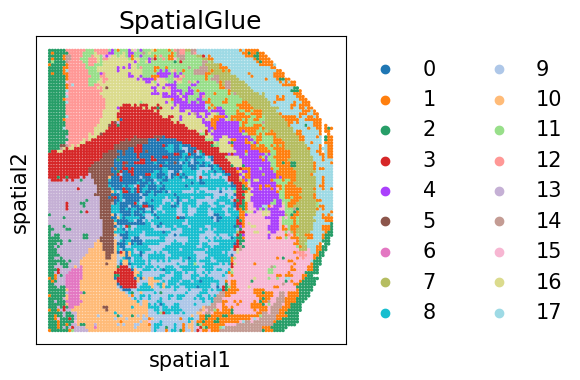

In [10]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata,basis='spatial',color='SpatialGlue',size=25,ax=ax)

In [11]:
adata4=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset7_Mouse_Brain_ATAC/3d-OT.h5ad')

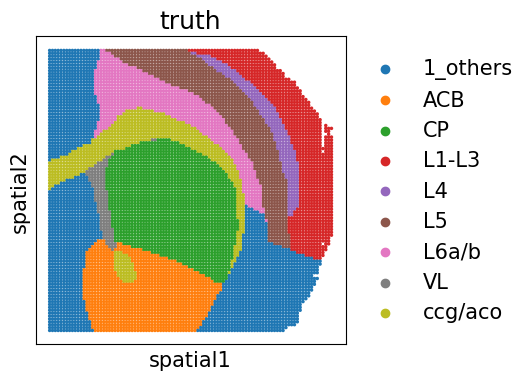

In [12]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots()
sc.pl.embedding(adata4,basis='spatial',color='truth',size=25,ax=ax)

In [13]:
import numpy as np
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

true_labels = np.array(adata4.obs['truth'])
cluster_labels = np.array(adata.obs['SpatialGlue'])

FMI = fowlkes_mallows_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("ARI:", ari)
print("NMI:", nmi)
print("AMI:", ami)
print("FMI:", FMI)
print("V-Measure:", v_measure)
print("Homogeneity:", homogeneity)

ARI: 0.294647486731135
NMI: 0.5231578813397528
AMI: 0.5216621956736063
FMI: 0.39297501351367903
V-Measure: 0.5231578813397528
Homogeneity: 0.6264003663946481


In [14]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/SpatialGlue/SpatialGlue_ATAC.h5ad',compression='gzip')